10-1 들어가며 <br>
10-2 우리가 만드는 언어모델 <br>
10-3 Seq-to-seq 문제 <br>
10-4 Seq-to-seq 구현 <br>
10-5 Attention (1)Bahdanau <br>
10-6 Attention (2) Luong Atttention <br>
10-7 트랜스포머로 가기 전 징검다리? <br>
10-8 마무리 <br>

### 10-2 우리가 만드는 언어모델
언어 모델(Language Model)이란, <b> 단어의 시퀀스를 보고 다음 단어에 확률을 할당</b>하는 모델 

언어 모델은 n-1개의 단어 시퀀스 w1, ..., wn-1가 주어졌을 때, n번째 단어 wn으로 무엇이 올지를 예측하는 확률 모델로 표현됨, 파라미터 θ로 모델링하는 언어 모델을 다음과 같이 표현할 수 있다. <br>
$ P(wn|w1,...,wn-1;θ)$ <br>
하지만 나중에는 꼭 시퀀스 형태의 Next Token Prediction 언어모델이 아니더라도, 주변 단어를 보고 중심 단어를 예측하는 형태로 언어모델을 구성하게 됨. <br>

<b>통계적 언어 모델(Statisical Language Model)</b><br>
https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/ <br>

<b>신경망 언어 모델 (Neural Network Language Model)</b><br>
NNLM의 시초는 Feed-Forward 신경망 언어 모델인데, 지금의 Embedding 레이어의 아디어인 모델이다. <br><br>


### 10-3 Sequence to Sequence 문제
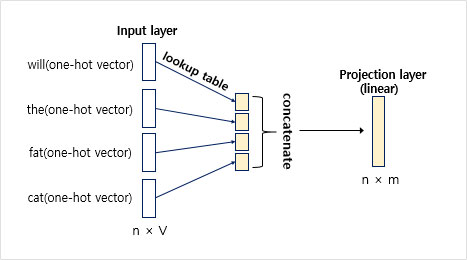 <br>
여러개의 단어(Embedding)를 합쳐 (Concatenate) 고정된 크기의 Weight를 linear로 처리하는 방식은 유연성에 한계가 있다. 단어의 개수에 무관하게 처리할 수 있는 네트워크가 필요했고 그것은 곧 <b>RNN의 고안</b>으로 이뤄졌다. RNN은 고정된 크기의 Weight가 선언되는 것은 동일하지만 입력을 순차적으로 "적립"하는 방식을 채택함으로써 유동적인 크기의 입력을 처리할 수 있었다.<br>

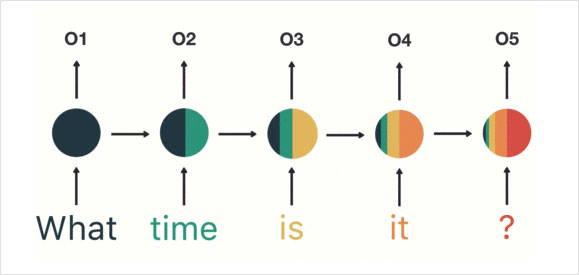 <br>
아직도 해결해야할 RNN의 2가지 문제점<br>
1. 하나의 Weight에 입력을 적립하다 보니 입력이 길어질수록 이전 입력에 대한 정보가 소실되는 <b> 기울기 소실(Vanishing Gradient)문제 </b> <br>
2. RNN 구조는 문장 생성엔 적합할지언정 <b>번역에 사용하기는 어렵다는 문제가 있다. </b> <br>
ex) 나는 -> <br>
나는 점심을 -> I lunch <br>
나는 점심을 먹는다 -> I lunch eat(?) <br><br>

번역에 있어서는 문장을 다 읽고 번역하는, 즉 <b>문장 전체를 보고나서 생성하는 구조</b>가 필요했다. 이에 구글이 Seq2Seq를 제안했다. <br><br>


### 10-4 Sequence to Sequence 구현
입력으로 <b>Embedding된 단어만 전달</b>하고 (Hidden State는 전달하지 않습니다), 출력은 Encoder와 Decoder 별로 상이함

<b>LSTM Encoder</b>

In [1]:
import tensorflow as tf

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(voca
                                                   b_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(enc_units) 
        # return_sequences 매개변수를 기본값 False로 전달

    def call(self, x):
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        output = self.lstm(x)
        print("LSTM Layer의 Output Shape:", output.shape)

        return output

print("슝~")

슝~


Embedding 레이어를 단어 사이즈와 Embedding 차원에 대해 선언을 한 후, 논문에서 소개한 대로 tf.keras.layers.LSTM(enc_units)으로 LSTM을 정의한다. TensorFlow 속 LSTM 모듈의 기본 반환 값은 최종 State 값이므로 return_sequences 나 return_state 값은 따로 조정하지 않는다 (기본: False). 즉, 우리가 정의해 준 Encoder 클래스의 반환 값이 곧 컨텍스트 벡터(Context Vector)가 되는 것이다.

In [ ]:
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

In [ ]:
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

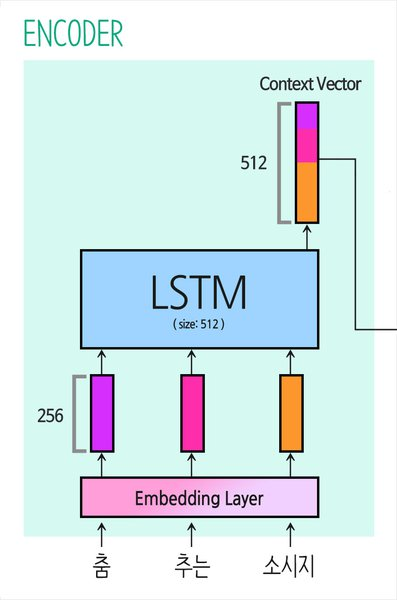 <br>
Encoder 클래스를 정의했다. 어떤 Source 문장을 Encoder에 읽히고, 그 반환 값인 LSTM의 최종 State 값을 Decoder에게 전달해 주면 된다. <br>

In [ ]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(dec_units,
                                         return_sequences=True) # return_sequences 매개변수를 True로 설정
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
        print("입력 Shape:", x.shape)

        x = self.embedding(x)
        print("Embedding Layer를 거친 Shape:", x.shape)

        context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                              repeats=x.shape[1], axis=1)
        x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
        print("Context Vector가 더해진 Shape:", x.shape)

        x = self.lstm(x)
        print("LSTM Layer의 Output Shape:", x.shape)

        output = self.fc(x)
        print("Decoder 최종 Output Shape:", output.shape)

        return self.softmax(output)

print("슝~")

Decoder는 Encoder와 구조적으로 유사하지만 결과물을 생성해야 하므로 Fully Connected 레이어가 추가되었고, 출력값을 확률로 변환해 주는 Softmax 함수도 추가되었습니다 (Softmax는 모델 내부에 포함시키지 않아도 훈련 과정에서 포함시키는 방법도 있습니다). 그리고 Decoder가 매 스텝 생성하는 출력은 우리가 원하는 번역 결과에 해당하므로 LSTM 레이어의 return_sequences 변수를 True로 설정하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [ ]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

In [ ]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

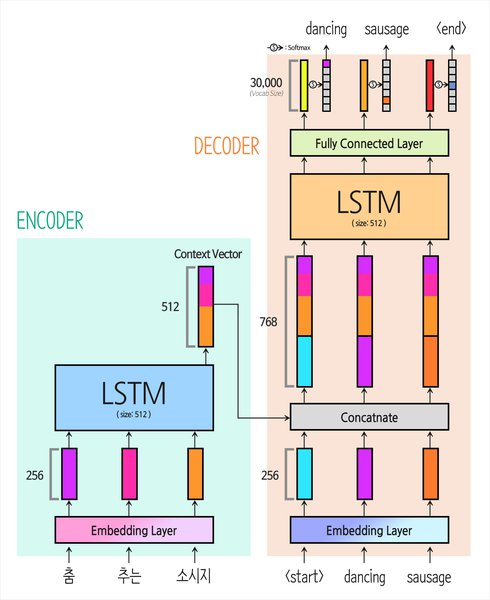 <br>
Encoder가 생성한 컨텍스트 벡터 v를 Embedding레이어를 가진 y값에 Concatenatae함. <br><br>


### 10-5 Attention! (1) Bahdanau Attention
Seq2Seq은 Encoder-Decoder 구조라는 딥러닝 모델의 큰 틀을 제시했고 이걸 아직도 사용<br>

<b>Bahdanau Attention</b> <br>
Bahdanau는 Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축하는 것이 손실을 야기한다고 주장했다. 즉, 짧은 문장에 대해서는 괜찮을지 모르겠으나 문장이 길어질수록 성능이 저하된다는 것. <br>
그는 Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘을 제안했다. <br>

- 원본 논문: https://arxiv.org/pdf/1409.0473.pdf <br>
- 정리 글: https://lovit.github.io/machine%20learning/2019/03/17/attention_in_nlp/ <br>

Sequence Labeling은 xi와 yi의 관계를 구하는 문제지만 Sequence to Sequence는 x1:n과 동일한 의미를 가지는 y1:m을 만드는 문제이다. <br><br>


<b>seq2seq과 attn-seq2seq, 뭐가 다른가?</b><br>
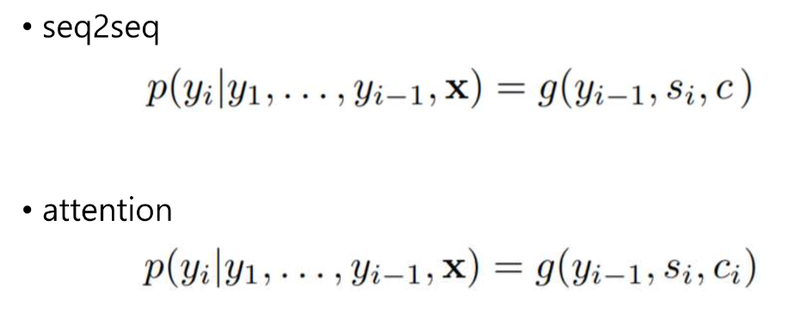 <br><br>
Bahdanau 논문 원문에 나오는 Encoder-Decoder 구조에 대한 수식을 seq2seq만 있는 경우와 attention이 적용된 경우로 나누어 비교해 보면, 약간의 notation을 수정해서 보면 단 한 군데만 빼고는 사실상 동일하다. <br>

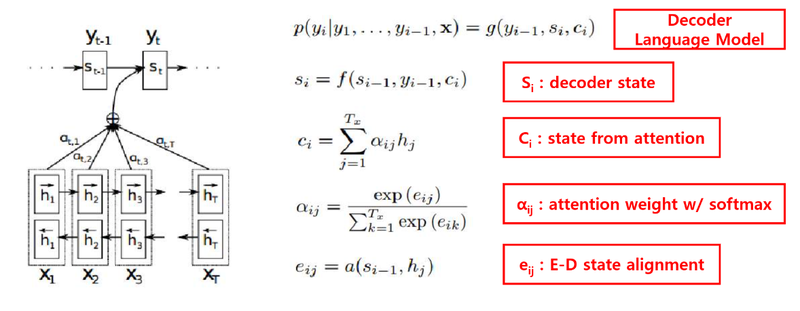 <br>
위 그림은 Bahdanau 논문 원문의 3.LEARNING TO ALIGN AND TRANSLATE의 내용을 바탕으로 재구성한 것이니다. 위 그림의 왼쪽 부분은 Xj를 입력으로, 
yi를 출력으로 하는 인코더-디코더 부분을 도식화한 것입니다. 여기서 유의해야 할 점은 <b>i는 디코더의 인덱스, j는 인코더의 인덱스</b>라는 점이다. <b>인코더가 X를 해석한 context ci는 디코더의 포지션 i에 따라 다르게 표현(represent)되어야 한다.</b> <br>

ex)'나는 밥을 먹었다'라는 한글 문장을 'I ate lunch'로 번역한다고 생각해 봅시다. 영어 문장의 첫 번째(i=0) 단어 'I'를 만들어야 할 때 인코더가 한글 문장을 해석한 컨텍스트 벡터에서는 '나는'이 강조되어야 하고, 영어 문장의 세 번째(i=2) 단어 'lunch'를 만들어야 할 때 인코더의 컨텍스트 벡터에서는 '밥을'이 강조되어야 한다는 것입니다. 디코더가 현재 시점 i에서 보기에 인코더의 어느 부분 j가 중요한가? 이 가중치가 바로 attention인 것입니다. <br>

얼마나 강조되어야 하는지를 나타내는 가중치는 어떻게 계산하냐면 <br>
$ \sum_{j}a_{i,j} = 1 $ <br>
αij가 바로 인코더의 j번째 hidden state hj가 얼마나 강조되어야 할지를 결정하는 가중치 역할을 한다. 이 가중치는 다시 디코더의 직전 스텝의 hidden state si−1와 hj의 유사도가 높을수록 높아지게 되어 있다. <br>


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W_decoder = tf.keras.layers.Dense(units)
        self.W_encoder = tf.keras.layers.Dense(units)
        self.W_combine = tf.keras.layers.Dense(1)

    def call(self, H_encoder, H_decoder):
        print("[ H_encoder ] Shape:", H_encoder.shape)

        H_encoder = self.W_encoder(H_encoder)
        print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)

        print("\n[ H_decoder ] Shape:", H_decoder.shape)
        H_decoder = tf.expand_dims(H_decoder, 1)
        H_decoder = self.W_decoder(H_decoder)

        print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

        score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
        print("[ Score_alignment ] Shape:", score.shape)

        attention_weights = tf.nn.softmax(score, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())

        context_vector = attention_weights * H_decoder
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

        W_size = 100

        print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

        attention = BahdanauAttention(W_size)

        enc_state = tf.random.uniform((1, 10, 512))
        dec_state = tf.random.uniform((1, 512))

        _ = attention(enc_state, dec_state)

Encoder의 모든 스텝에 대한 Hidden State를 100차원의 벡터 공간으로 매핑 (1, 10, 100) 하고, Decoder의 현재 스텝에 대한 Hidden State 역시 100차원의 벡터 공간으로 매핑 (1, 1, 100)해 두 State의 합으로 정의된 Score (1, 10, 1) 를 구하는 모습이다. Softmax를 거쳐 나온 값은 0-1 사이의 값으로 각 단어가 차지하는 비중을 의미하겠죠? 예시에서는 랜덤한 값을 사용했기 때문에 비중이 비슷비슷하지만 실제 단어로 적용시켜보면 유사한 단어에 높은 비중을 할당하게 된다! 그것을 시각화하면 아래와 같은 그림으로 나타나짐. <br>
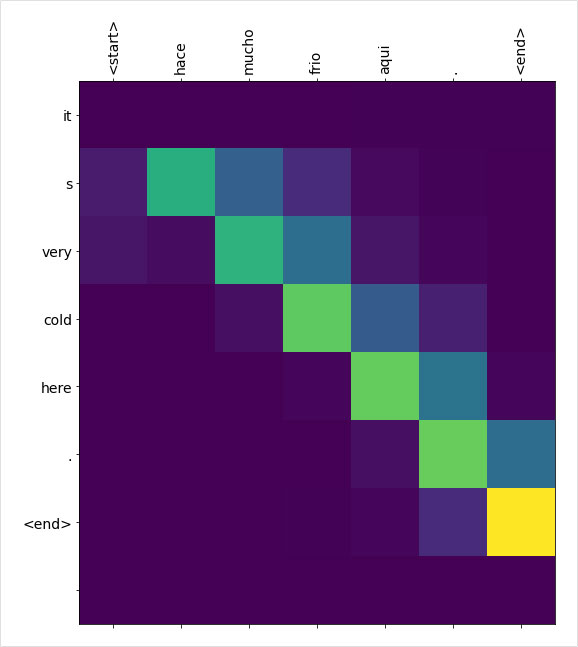 <br><br>


### 10-6 Attention! (2) Luong Attention
<b>Luong Attention</b>은 Bahdanau의 방식을 약간 발전시킨 형태이다. Decoder의 현재 Hidden State를 구하기 위해 한 스텝 이전의 Hidden State를 활용하는 것은 연산적으로 비효율적이다. 이는 RNN의 연산 형태 때문이다.

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W_combine = tf.keras.layers.Dense(units)

    def call(self, H_encoder, H_decoder):
        print("[ H_encoder ] Shape:", H_encoder.shape)

        WH = self.W_combine(H_encoder)
        print("[ W_encoder X H_encoder ] Shape:", WH.shape)

        H_decoder = tf.expand_dims(H_decoder, 1)
        alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
        print("[ Score_alignment ] Shape:", alignment.shape)

        attention_weights = tf.nn.softmax(alignment, axis=1)
        print("\n최종 Weight:\n", attention_weights.numpy())

        attention_weights = tf.squeeze(attention_weights, axis=-1)
        context_vector = tf.matmul(attention_weights, H_encoder)

        return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징이다. 어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능하다

### 10-7 트랜스포머로 가기 전 징검다리?

GNMT(Google Neural machine Tranlsation)후에 등장한 것이 Transformer이다. 앞서 언급한 레이어를 쌓는 구조나 Residual Connection이 트랜스포머와 굉장히 유사하다. <br>
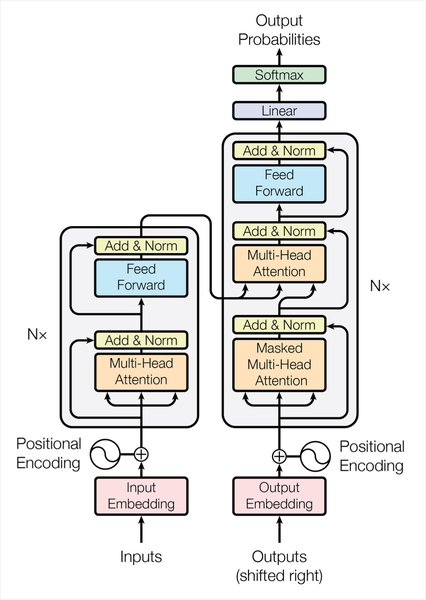 <br>

트랜스포머 모델은 Multi-Head Attention이라는 개념을 도입해 폭넓은 문맥을 파악하게 하고, 기존의 RNN 구조를 완전히 탈피하여 연산 속도 측면에서도 혁신적인 발전이었다. 지금까지도 트랜스포머를 기반으로 한 모델들이 각 분야에서 최고의 성능을 내고 있다. <br><br>

### 10-8 마무리하며 
Bahdanau, Luong Attention에 대해서 간단하게 정리하자면, <br>
Attention은 번역 모델에서 입력 문장의 단어와 출력 문장의 단어 사이의 매핑 관계를 찾아내는 메커니즘이다. 이를 통해 입력 문장의 모든 단어를 고려하면서 출력 문장의 각 단어를 예측한다. 그러나 문장이 길어질수록 Attention 계산에 필요한 계산량이 많아지고, 희소성 문제 등 다양한 문제점이 발생합니다. <br>
Bahdanau Attention은 전체 입력 문장에 대한 정보를 고려하여 출력을 생성하는 반면, Luong Attention은 현재 예측하려는 출력 단어와 관련된 입력 단어에만 집중하여 출력을 생성한다. 둘 중 어떤 어텐션을 사용할지는 데이터와 모델의 성능에 따라 선택할 수 있다.